# Sungwon Lee
## 017473950
### Bonus Assignment 1

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("fashion_mnist1.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,2,...,116,30,0,0,0,0,1,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,6,...,18,0,0,0,0,0,0,0,0,0


# (2 pts) Dimension reduction using principal component analysis (PCA)

## 1.1

In [236]:
pixels = df.iloc[:, 1:].values
labels = df.iloc[:, 0].values

In [253]:
# standardization
pixels = (pixels - pixels.mean())/pixels.std()
# pixels = pixels/255.0

In [254]:
# make the dataset to be centered
X_centered = pixels - pixels.mean(axis=0)

In [255]:
from numpy import linalg

U, S, V = linalg.svd(X_centered)

In [256]:
c1 = V.T[:, 0]
c2 = V.T[:, 1]

In [257]:
Projected = X_centered @ np.column_stack((c1, c2))

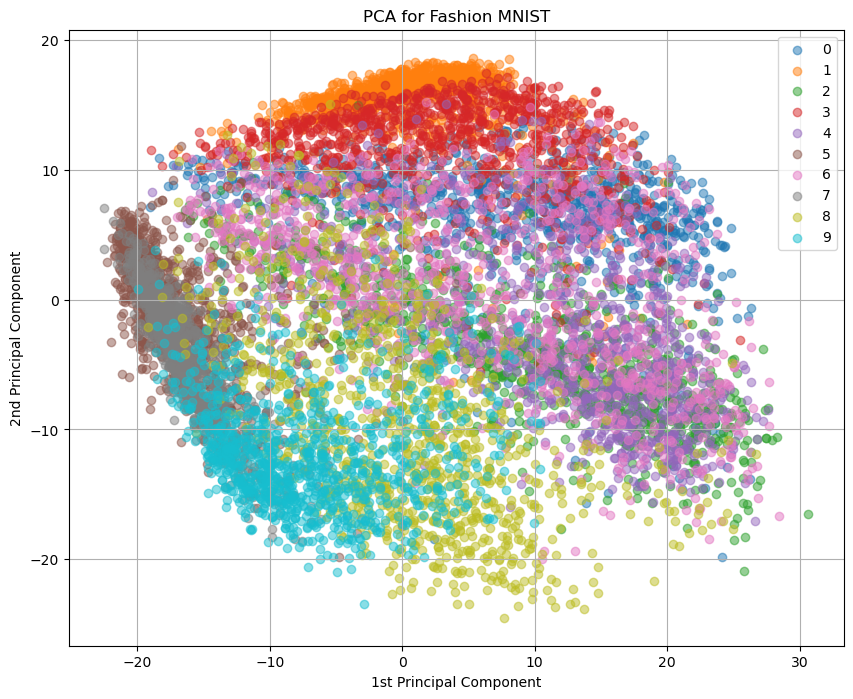

In [258]:
plt.figure(figsize=(10, 8))
colors = plt.get_cmap('tab10', 10) 
labels_range = labels.max()
for label in range(labels_range+1):
    plt.scatter(Projected[labels == label, 0], Projected[labels == label, 1], 
                color=colors(label), label=f'{label}', alpha=0.5)

plt.title('PCA for Fashion MNIST')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.legend()
plt.grid()
plt.show()

## 1.2

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("fashion_mnist1.csv")
pixels = df.iloc[:, 1:].values
labels = df.iloc[:, 0].values
X_centered = pixels - pixels.mean(axis=0)
U, S, V = linalg.svd(X_centered)

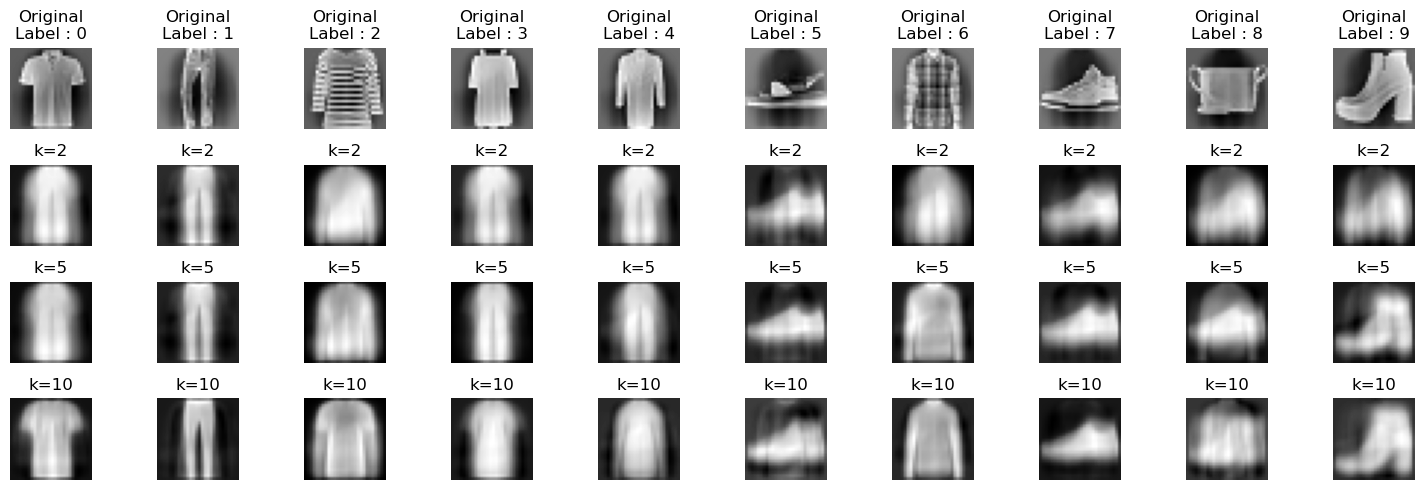

In [260]:
ks = [2, 5, 10]

get_idx = []
for label in range(10):
    idx = np.where(labels == label)[0][5]  
    get_idx.append(idx)

fig, axes = plt.subplots(len(ks)+1, 10, figsize=(15, 5))

# Original Image
for col, idx in enumerate(get_idx):
    original_image = X_centered[idx].reshape(28, 28)
    axes[0, col].imshow(original_image, cmap='gray')
    axes[0, col].set_title(f'Original\nLabel : {labels[idx]}')
    axes[0, col].axis('off')  

# Compressed Image
for row, k in enumerate(ks):
    U2, S2, V2 = U[:, :k], np.diag(S[:k]), V[:k, :]
    
    A = U2 @ S2 @ V2 + pixels.mean(axis=0)
    
    for col, idx in enumerate(get_idx):
        Img = A[idx].reshape(28, 28)  
        axes[row + 1, col].imshow(Img, cmap='gray')
        axes[row + 1, col].set_title(f'k={k}')
        axes[row + 1, col].axis('off')  

plt.tight_layout()
plt.show()

# 2. (5 pts) Dimension reduction using t-SNE

## 2.1

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

class TSNE:
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=10, random_state=None):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state

    def _compute_pairwise_distances(self, X):
        """Compute pairwise Euclidean distances."""
        return pairwise_distances(X)

    def _conditional_probabilities(self, distances, sigma):
        """Compute conditional probabilities P_j|i."""
        num_samples = distances.shape[0]
        P = np.zeros((num_samples, num_samples))

        for i in range(num_samples):
            # Compute the conditional probability for each point
            exp_distances = np.exp(-distances[i] ** 2 / (2 * sigma[i] ** 2))
            P[i] = exp_distances / np.sum(exp_distances)
            P[i][i] = 0  # Set self-probability to 0

        return P

    def _compute_P(self, X):
        """Compute symmetric joint probabilities P."""
        distances = self._compute_pairwise_distances(X)
        # Compute variance sigma for each data point
        sigma = np.std(distances, axis=1)  # Standard deviation of distances
        P = self._conditional_probabilities(distances, sigma)
        # Symmetrize P
        P = (P + P.T) / (2 * X.shape[0])
        return P

    def _joint_probabilities(self, Y):
        """Compute Q probabilities using a t-distribution."""
        num_samples = Y.shape[0]
        Q = np.zeros((num_samples, num_samples))

        for i in range(num_samples):
            for j in range(num_samples):
                if i != j:
                    dist = np.sum((Y[i] - Y[j]) ** 2)
                    Q[i, j] = 1 / (1 + dist)

        # Normalize Q
        Q /= np.sum(Q)
        return Q

    def _kl_divergence(self, P, Q):
        """Compute Kullback-Leibler divergence."""
        return np.sum(P * np.log(P / (Q + 1e-10)))

    def _gradient(self, P, Q, Y):
        """Compute gradient of the cost function."""
        num_samples = Y.shape[0]
        grad = np.zeros_like(Y)

        for i in range(num_samples):
            for j in range(num_samples):
                if i != j:
                    diff = Y[i] - Y[j]
                    grad[i] += (P[i, j] - Q[i, j]) * diff / (1 + np.sum(diff ** 2))

        return grad

    def fit_transform(self, X):
        """Fit the model to the data and return the embedded coordinates."""
        num_samples = X.shape[0]
        
        # Compute joint probabilities P
        P = self._compute_P(X)
        
        # Initialize Y randomly
        if self.random_state is not None:
            np.random.seed(self.random_state)
        Y = np.random.randn(num_samples, self.n_components)

        # Gradient descent optimization
        for _ in range(self.n_iter):
            Q = self._joint_probabilities(Y)
            C = self._kl_divergence(P, Q)
            grad = self._gradient(P, Q, Y)
            Y -= self.learning_rate * grad
        
        return Y

# Example usage
if __name__ == "__main__":
    # Create some example data
    X = pixels

    # Initialize and fit t-SNE
    tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=42)
    Y = tsne.fit_transform(X)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(Y[:, 0], Y[:, 1], c=iris.target, cmap='viridis', edgecolor='k', s=50)
    plt.title("t-SNE Visualization of Iris Dataset")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.colorbar(label='Classes')
    plt.show()


C:\Users\pumad\AppData\Local\Temp\ipykernel_26072\3400934582.py:57: RuntimeWarning: divide by zero encountered in log
  return np.sum(P * np.log(P / (Q + 1e-10)))
C:\Users\pumad\AppData\Local\Temp\ipykernel_26072\3400934582.py:57: RuntimeWarning: invalid value encountered in multiply
  return np.sum(P * np.log(P / (Q + 1e-10)))
